In [1]:
# Standard librares
import numpy as np
from numpy import pi
from scipy.constants import epsilon_0, mu_0
from scipy.special import jv, jvp, hankel2, h2vp
from matplotlib import pyplot as plt
from scipy.sparse import dia_matrix
from scipy.linalg import norm
from numpy import random as rnd

# Transform cartesian coordinates into polar ones
def cart2polar(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    phi[phi<0] = 2*pi + phi[phi<0]
    return rho, phi

In [3]:
def update_archive(PX, PE, fx, gxbest, gebest, fx_gbest, MAX_ARCHIVE):
    """Update the archive given a population of solutions."""

    N = len(gxbest)  # Current size of Archive

    # If the Archive is empty, the first solution is added
    if N == 0:
        gxbest.append(PX[0, :].copy())
        gebest.append(PE[0, :].copy())
        fx_gbest.append(fx[0, :].copy())
        i0 = 1
    else:
        i0 = 0

    # For each solution in the population 
    for i in range(i0, PX.shape[0]):

        # Compare the solution to the ones in the Archive
        dominated_solutions, nondominated_solution = compare2archive(fx[i, :], fx_gbest)

        # The solution is dominated by any solution in the Archive, skip to the next
        if not nondominated_solution:
            continue

        # If the solution dominates one or more solutions in the Archive
        elif len(dominated_solutions) > 0:

            # Remove the dominated solutions
            for j in range(len(dominated_solutions)-1, -1, -1):
                gxbest.pop(dominated_solutions[j])
                gebest.pop(dominated_solutions[j])
                fx_gbest.pop(dominated_solutions[j])

            # Add the new one
            gxbest.append(PX[i, :].copy())
            gebest.append(PE[i, :].copy())
            fx_gbest.append(fx[i, :].copy())

        # If it does not dominate nor is dominated and the Archive is not full, add it
        elif len(gxbest) < MAX_ARCHIVE:
            gxbest.append(PX[i, :].copy())
            gebest.append(PE[i, :].copy())
            fx_gbest.append(fx[i, :].copy())

        # Otherwise...
        else:

            # add it...
            gxbest.append(PX[i, :].copy())
            gebest.append(PE[i, :].copy())
            fx_gbest.append(fx[i, :].copy())

            # Compute the Crowding Distance measure
            dist = crowding_distance(fx_gbest)

            # Remove the one with the smallest measure
            j = np.argmin(dist)
            gxbest.pop(j)
            gebest.pop(j)
            fx_gbest.pop(j)

    # Keep the archive sorted
    gxbest, gebest, fx_gbest = sort_archive(gxbest, gebest, fx_gbest)
    return gxbest, gebest, fx_gbest

def compare2archive(fx0, fx):
    """Determine if a solution dominates or is dominated by the solutions in the Archive."""
    dominated_solutions = []
    nondominated_solution = True
    for i in range(len(fx)):

        # It dominates
        if fx0[0] <= fx[i][0] and fx0[1] <= fx[i][1]:
            dominated_solutions.append(i)

        # It is dominated
        elif fx0[0] >= fx[i][0] and fx0[1] >= fx[i][1]:
            nondominated_solution = False
            break

    return dominated_solutions, nondominated_solution

def sort_archive(PX, PE, fx):
    """Sort the archive."""
    array = []
    for i in range(len(fx)):
        array.append(fx[i][0])
    idx = np.argsort(array)
    new_px, new_pe, new_fx = [], [], []
    for i in range(len(fx)):
        new_px.append(PX[idx[i]])
        new_pe.append(PE[idx[i]])
        new_fx.append(fx[idx[i]])
    return new_px, new_pe, new_fx

def crowding_distance(fx_gbest):
    """Crowding Distance measure."""
    M = len(fx_gbest)
    dist = np.zeros(M)
    fx = np.zeros((2, M))
    for m in range(M):
        fx[0, m] = fx_gbest[m][0]
        fx[1, m] = fx_gbest[m][1]
    idx = np.argsort(fx[0, :])
    dist[idx[0]] = np.inf
    dist[idx[-1]] = np.inf
    for m in range(1, M-1):
        dist[idx[m]] += (fx[0, idx[m+1]]-fx[0, idx[m-1]])/(fx[0, idx[-1]]-fx[0, idx[0]])
    idx = np.argsort(fx[1, :])
    for m in range(1, M-1):
        dist[idx[m]] += (fx[1, idx[m+1]]-fx[1, idx[m-1]])/(fx[1, idx[-1]]-fx[1, idx[0]])
    return dist

# É possível achar alguma solução que domine a solução analítica?

Seja o problema multiobjetivo definido pelas equações de dados e de estados:

$$ \min f_0(\chi, E_{z}) = \sum_{m=1}^M |E_{z,m}^s + \sum_{n=1}^N h_{mn}\chi_nE_{z,n}|^2 \\
\min f_1(\chi, E_{z}) = \sum_{n=1}^N |E_{z,n}^i - E_{z,n} - \sum_{m=1}^M h_{nm}\chi_mE_{z,m}|^2 $$

In [2]:
def feval(X, Ez, HD, HS, Esz, Eiz):
    f0 = np.sum(np.abs(Esz + HD @ X @ Ez)**2)
    f1 = np.sum(np.abs(Eiz - Ez - HS @ X @ Ez)**2)
    return f0, f1

A pergunta é: pode existir alguma solução que domine a solução exata para o problema? Vamos considerar o problema analítico do espalhamento sobre o cilindro circular dielétrico. Para esse caso, a avaliação dos dois objetivos para a solução analítica é:

In [4]:
# Parameters
lambdab = 1.0  # [1/m]
a = 0.25*lambdab
epsilon_rd = 2.0
Ro = 2*lambdab
M = 10
resolution = (10, 10)

# Constants
E0 = 1.0  # [V/m]
kb = 2*pi/lambdab
f = 1/np.sqrt(epsilon_0*mu_0)/lambdab
omega = 2*pi*f
Lx, Ly = lambdab, lambdab
kd = omega*np.sqrt(epsilon_rd*epsilon_0*mu_0)
lamdad = 2*pi/kd
epsilon_d = epsilon_rd*epsilon_0

# Computing scattered field
NT = 100
n = np.arange(-NT, NT+1, dtype=float)
an = -jv(n, kb*a)/hankel2(n, kb*a) * (epsilon_d*jvp(n, kd*a)/(epsilon_0*kd*a*jv(n, kd*a)) - jvp(n, kb*a)/(kb*a*jv(n, kb*a))) / (epsilon_d*jvp(n, kd*a)/(epsilon_0*kd*a*jv(n, kd*a)) - h2vp(n, kb*a)/(kb*a*hankel2(n, kb*a)))
phi = np.linspace(0, 2*pi, M, endpoint=False)
Esz = np.zeros(phi.size, dtype=complex)
for i in range(M):
    Esz[i] = E0*np.sum(1j**(-n)*an*hankel2(n, kb*Ro)*np.exp(1j*n*phi[i]))
xm, ym = Ro*np.cos(phi), Ro*np.sin(phi)

# Computing the incident field
N = resolution[0]*resolution[1]
dy, dx = Ly/resolution[0], Lx/resolution[1]
x, y = np.meshgrid(np.arange(-Lx/2 + dx/2, Lx/2, dx), np.arange(-Ly/2 + dy/2, Ly/2, dy))
rho, phi = cart2polar(x, y)
Eiz = E0*np.exp(1j*kb*rho*np.cos(phi)).flatten()
cell_area = np.sqrt(dx*dy/pi)

# Data equation
HD = np.zeros((M, N), dtype=complex)
for m in range(M):
    R = np.sqrt((x-xm[m])**2 + (y-ym[m])**2).flatten()
    HD[m, :] = 1j*pi*kb*cell_area/2*jv(1, kb*cell_area)*hankel2(0, kb*R)

# State Equation
HS = np.zeros((N, N), dtype=complex)
for k in range(N):
    i, j = np.unravel_index(k, resolution)
    R = np.sqrt((x-x[i, j])**2 + (y-y[i, j])**2).flatten()
    HS[k, :] = 1j*pi*kb*cell_area/2*jv(1, kb*cell_area)*hankel2(0, kb*R)
    HS[k, R==0] = 1j/2*(pi*kb*cell_area*hankel2(1, kb*cell_area)-2j)

Exact solution evaluation
Data Equation Residual: 2.191e-02
State Equation Residual: 1.875e+02


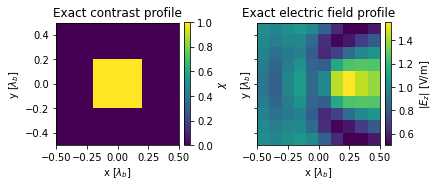

In [5]:
# Exact contrast profile
chi_exact = np.zeros(x.shape)
chi_exact[x**2+y**2 <= a**2] = epsilon_rd-1

# Exact electric field profile
Ez_exact = np.zeros(x.shape, dtype=complex)
cn = 1/jv(n, kd*a)*(jv(n, kb*a) + an*hankel2(n, kb*a)) # Problem 5-34, Harrington
circle = rho <= a # object nodes
not_circle = np.logical_not(circle) # background nodes
for ni in range(n.size):
    Ez_exact[circle] = (Ez_exact[circle]
                        + E0*1j**(-n[ni])*cn[ni]*jv(n[ni], kd*rho[circle])*np.exp(1j*n[ni]*phi[circle])) # Problem 5-34, Harrington
    Ez_exact[not_circle] = (Ez_exact[not_circle]
                            + E0*1j**(-n[ni])*(jv(n[ni], kb*rho[not_circle])
                                               + an[ni]*hankel2(n[ni], kb*rho[not_circle]))*np.exp(1j*n[ni]*phi[not_circle])) # (5-107), Harrington

fig, axis = plt.subplots(ncols=2, sharey=True)
fig.subplots_adjust(hspace=.5, wspace=.5)

# Plot contrast profile
img = axis[0].imshow(chi_exact, extent=[-Lx/2/lambdab, Lx/2/lambdab, -Ly/2/lambdab, Ly/2/lambdab])
axis[0].set_xlabel(r'x [$\lambda_b$]')
axis[0].set_ylabel(r'y [$\lambda_b$]')
axis[0].set_title('Exact contrast profile')
clb = fig.colorbar(img, ax=axis[0], fraction=0.046, pad=0.04)
clb.set_label(r'$\chi$')

# Plot electric field profile
img = axis[1].imshow(np.abs(Ez_exact), extent=[-Lx/2/lambdab, Lx/2/lambdab, -Ly/2/lambdab, Ly/2/lambdab])
axis[1].set_xlabel(r'x [$\lambda_b$]')
axis[1].set_ylabel(r'y [$\lambda_b$]')
axis[1].set_title('Exact electric field profile')
clb = fig.colorbar(img, ax=axis[1], fraction=0.046, pad=0.04)
clb.set_label(r'$|E_z|$ [V/m]')

# Evaluate the exact solution
X = dia_matrix((chi_exact.flatten(), 0), shape=(N, N))
Ez = Ez_exact.flatten()
fx0exct, fx1exct = feval(X, Ez, HD, HS, Esz, Eiz)
print('Exact solution evaluation')
print('Data Equation Residual: %.3e' % fx0exct)
print('State Equation Residual: %.3e' % fx1exct)

A diferença de grandeza entre os dois objetivos se deve ao fato de que o conjunto de equações de estados é bem maior. Por isso, são muito mais resíduos a serem somados.

Nesse estudo, nós iremos utilizar o algoritmo do PSO com inicialização de soluções de forma totalmente aleatória. Esse tipo de inicialização é bem ruim e dificilmente o algoritmo chegaria a soluções com valor de função objetivo perto da solução analítica. Por causa disso, após essa inicialização das soluções, a primeira solução será substituída pela solução exata. Isso fará o algoritmo concentrar suas soluções perto da solução analítica, excluindo outras regiões do espaço que poderiam talvez terem valores parecidos. Todavia, poderemos verificar se tem outras soluções não-dominadas nessa região.

In [6]:
NPAR = 250
w = .4
c1 = c2 = 2.0
MAX_ARCHIVE = 20
NITER = 20000

In [7]:
NVAR = resolution[0]*resolution[1]  # Number of variables

PX = rnd.rand(NPAR, NVAR)  # array of contrast particles
PE = rnd.normal(size=(NPAR, NVAR)) + 1j*rnd.normal(size=(NPAR, NVAR))  # array of electric field particles
vx = np.zeros((NPAR, NVAR), dtype=complex)  # array of contrast velocities
ve = np.zeros((NPAR, NVAR), dtype=complex)  # array of electric field velocities
fx = np.zeros((NPAR, 2))  # evaluation of each particle

PX[0, :] = chi_exact.flatten()
PE[0, :] = Ez_exact.flatten()

# Evaluate particles
for i in range(NPAR):
    X = dia_matrix((PX[i, :].flatten(), 0), shape=(N, N))
    Ez = PE[i, :].flatten()
    fx[i, 0], fx[i, 1] = feval(X, Ez, HD, HS, Esz, Eiz)

# Personal best particles
pxbest = np.zeros((NPAR, NVAR), dtype=complex)
pebest = np.zeros((NPAR, NVAR), dtype=complex)
fx_pbest = np.inf*np.ones(fx.shape) 

# Archive - Global best particles
gxbest = []
gebest = []
fx_gbest = []

In [8]:
for it in range(NITER):

    # Update pbest
    for n in range(NPAR):

        # If it the new particle is a new non-dominated one
        if not(fx[n, 0] >= fx_pbest[n, 0] and fx[n, 1] >= fx_pbest[n, 1]):
            pxbest[n, :] = PX[n, :]
            pebest[n, :] = PE[n, :]
            fx_pbest[n, :] = fx[n, :]

    # Update Archive
    gxbest, gebest, fx_gbest = update_archive(PX, PE, fx, gxbest, gebest, fx_gbest, MAX_ARCHIVE)

    # Calculate particle velocity
    idx = rnd.randint(len(fx_gbest), size=NPAR)  # Random choice of solutions in the Archive
    for n in range(NPAR):
        vx[n, :] = w*vx[n, :] + c1*rnd.rand(1, NVAR)*(pxbest[n, :]-PX[n, :]) + c2*rnd.rand(1, NVAR)*(gxbest[idx[n]]-PX[n, :])
        ve[n, :] = w*ve[n, :] + c1*rnd.rand(1, NVAR)*(pebest[n, :]-PE[n, :]) + c2*rnd.rand(1, NVAR)*(gebest[idx[n]]-PE[n, :])

    # Update particle position
    PX = PX + vx
    PE = PE + ve

    # Boundary condition for contrast
    PX[PX < 0] = 0

    # Update particle evalution
    for i in range(NPAR):
        X = dia_matrix((PX[i, :].flatten(), 0), shape=(N, N))
        Ez = PE[i, :].flatten()
        fx[i, 0], fx[i, 1] = feval(X, Ez, HD, HS, Esz, Eiz)  # Evaluate particles

    if it == 0:
        print('Iterations: 1/%d' % NITER)
    elif it == NITER-1:
        print('Iterations %d/' % NITER + '%d' % NITER)
    elif NITER == 10 or (it+1) % (NITER/10) == 0:
        print('Iterations: %d/' % (it+1) + '%d' % NITER)

Iterations: 1/20000
Iterations: 2000/20000
Iterations: 4000/20000
Iterations: 6000/20000
Iterations: 8000/20000
Iterations: 10000/20000
Iterations: 12000/20000
Iterations: 14000/20000
Iterations: 16000/20000
Iterations: 18000/20000
Iterations 20000/20000


## Results

A fronteira Pareto obtida no final das iterações é:

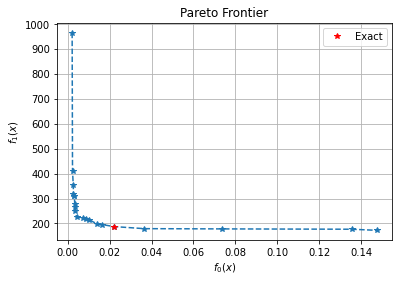

In [9]:
pareto = np.zeros((2, len(fx_gbest)))

for i in range(len(fx_gbest)):
    pareto[0, i] = fx_gbest[i][0]
    pareto[1, i] = fx_gbest[i][1]

plt.plot(pareto[0, :], pareto[1, :], '--*')
plt.plot(fx0exct, fx1exct, 'r*', label='Exact')
plt.xlabel(r'$f_0(x)$')
plt.ylabel(r'$f_1(x)$')
plt.title('Pareto Frontier')
plt.legend()
plt.grid()
plt.show()

Cada imagem presente no conjunto Pareto pode ser visualizada abaixo:

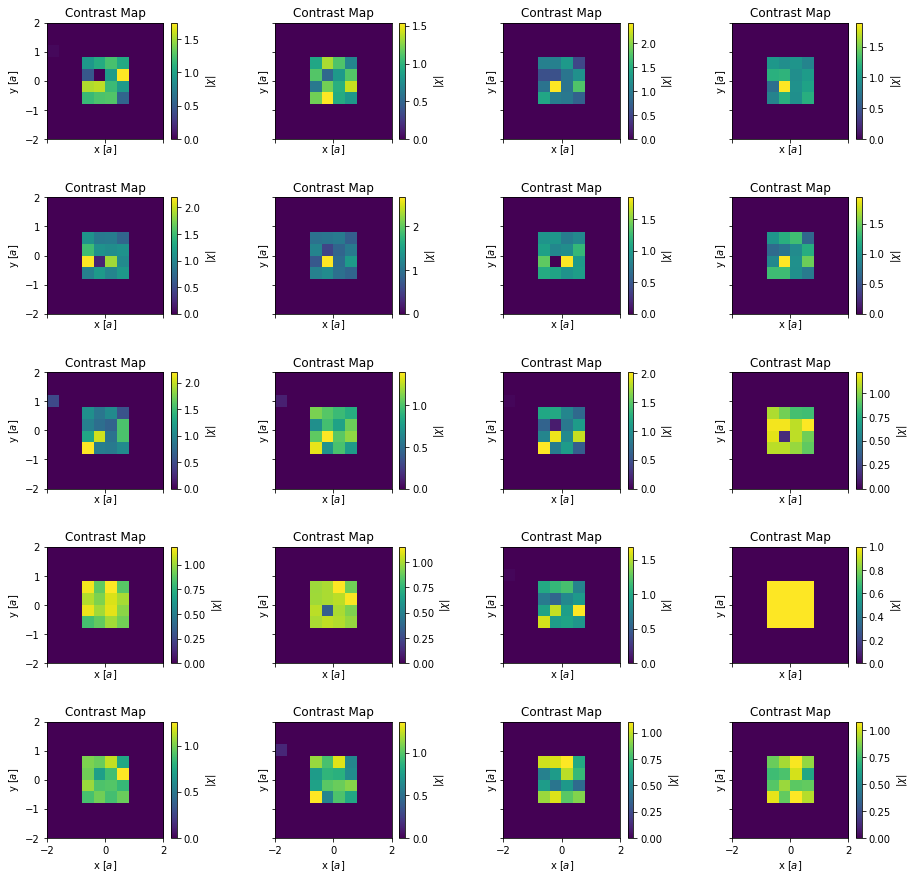

In [10]:
nrows = int(np.ceil(np.sqrt(len(gxbest))))
ncols = int(np.ceil((len(gxbest)/nrows)))

fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15), sharey=True, sharex=True)
fig.subplots_adjust(hspace=.5, wspace=.5)
axis = axis.flatten()

for i in range(axis.size):

    if i < len(gxbest):

        sb1 = axis[i].imshow(np.abs(gxbest[i].reshape(resolution)), extent=[-2, 2, -2, 2], origin='lower')
        axis[i].set_xlabel(r'x [$a$]')
        axis[i].set_ylabel(r'y [$a$]')
        axis[i].set_title('Contrast Map')
        cbar1 = fig.colorbar(sb1, ax=axis[i])
        cbar1.set_label(r'$|\chi|$')

    else:
        axis[i].set_visible(False)

plt.show()

A fronteira Pareto final contém 20 soluções não-dominadas, incluindo a solução exata dada na primeira geração. Vemos que essas soluções se parecem com a exata e foram obtidas com variações dentro da região do círculo. Ou seja, parece que qualquer variação em pontos fora da região do círculo retorna uma solução pior (exceto por três soluções nessa fronteira que têm pequenas variações em um píxel de background). Por isso é interessante notar como o formato do solução exata se preservou.

Por causa da estratégia feita na inicialização do problema que levou a uma convergência a uma região do espaço de busca (região da solução exata), é difícil responder se teria alguma outra região do espaço que teria soluções não-dominadas por essas ou que dominam. No entanto, é interessante destacar que, se a solução exata se preservou na fronteira Pareto por 20000 gerações, então é difícil acreditar que exista outra solução nessa região que domine todas as outras.

Outras coisas que podem ser notadas nos resultados é a faixa de valores dos resíduos da equação de estados (bem maior que da equação de dados) e a posição da solução analítica dentro da fronteira Pareto (à margem da região de joelho da fronteira). A primeira observação pode ser explicada talvez pelo fato que o conjunto de equações de estados é bem, e por isso, pequenas variações têm bastante impacto. A segunda talvez não tenha uma explicação ainda, mas é interessante notar que várias soluções tanto à esquerda como à direita tem pequenas variações de resíduos da equação de estados, ou seja, sendo mais preponderante a diferença em relação aos resíduos da equação de dados. Ou seja, existem soluções além da exata que possuem um resíduo nos dados significativamente menor e que não representam um desvio tão grande em relação ao resíduo de estados.